In [1]:
import open3d as o3d
import numpy as np
import math
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import math
from functools import reduce

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
pcd = o3d.io.read_point_cloud("data/mesh.ply")
axes = o3d.geometry.TriangleMesh.create_coordinate_frame()


In [27]:
aabb = pcd.get_axis_aligned_bounding_box()
aabb.color = (1, 0, 0)
obb = pcd.get_oriented_bounding_box()
obb.color = (0, 1, 0)

In [21]:
mesh_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=10.0)
mesh_sphere.compute_vertex_normals()

TriangleMesh with 762 points and 1520 triangles.

In [18]:
print("Downsample the point cloud with a voxel of 0.05")
downpcd = pcd.voxel_down_sample(voxel_size=0.05)
o3d.visualization.draw_geometries([downpcd])

Downsample the point cloud with a voxel of 0.05


In [31]:
print("Recompute the normal of the downsampled point cloud")
downpcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
o3d.visualization.draw_geometries([downpcd],
                                  point_show_normal=True)

Recompute the normal of the downsampled point cloud


In [20]:
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=9)
print(mesh)
o3d.visualization.draw_geometries([mesh])

run Poisson surface reconstruction
[Open3D DEBUG] Input Points / Samples: 130864 / 97359
[Open3D DEBUG] #   Got kernel density: 0.056 (s), 277.438 (MB) / 277.438 (MB) / 277 (MB)
[Open3D DEBUG] #     Got normal field: 0.647 (s), 335.012 (MB) / 335.012 (MB) / 335 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 8.689320e-06 / 1.137119e+00
[Open3D DEBUG] #       Finalized tree: 0.303000 (s), 388.426 (MB) / 388.426 (MB) / 401 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.207000 (s), 363.305 (MB) / 388.426 (MB) / 401 (MB)
[Open3D DEBUG] #Set point constraints: 0.0999999 (s), 342.063 (MB) / 388.426 (MB) / 401 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 1476455 / 1677768 / 9609
[Open3D DEBUG] Memory Usage: 342.063 MB
[Open3D DEBUG] # Linear system solved: 0.975 (s), 381.566 (MB) / 388.426 (MB) / 401 (MB)
[Open3D DEBUG] Got average: 0.00799990 (s), 338.879 (MB) / 388.426 (MB) / 401 (MB)
[Open3D DEBUG] Iso-Value: 4.997838e-01 = 6.540370e+04 / 1.308640e+05
[Open3D DEBUG] #    

In [29]:
o3d.visualization.draw_geometries([pcd, axes, aabb, obb])

In [3]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=10000)


[a, b, c, d] = plane_model

In [4]:
plane_pcd = pcd.select_by_index(inliers)
plane_pcd.paint_uniform_color([1.0, 0, 0])
stockpile_pcd = pcd.select_by_index(inliers, invert=True)
stockpile_pcd.paint_uniform_color([0, 0, 1.0])

o3d.visualization.draw_geometries([plane_pcd, stockpile_pcd, axes])

In [5]:
plane_pcd = plane_pcd.translate((0,0,d/c))
stockpile_pcd = stockpile_pcd.translate((0,0,d/c))

cos_theta = c / math.sqrt(a**2 + b**2 + c**2)
sin_theta = math.sqrt((a**2+b**2)/(a**2 + b**2 + c**2))
u_1 = b / math.sqrt(a**2 + b**2 )
u_2 = -a / math.sqrt(a**2 + b**2)

rotation_matrix = np.array([[cos_theta + u_1**2 * (1-cos_theta), u_1*u_2*(1-cos_theta), u_2*sin_theta],
                            [u_1*u_2*(1-cos_theta), cos_theta + u_2**2*(1- cos_theta), -u_1*sin_theta],
                            [-u_2*sin_theta, u_1*sin_theta, cos_theta]])

plane_pcd.rotate(rotation_matrix)
stockpile_pcd.rotate(rotation_matrix)
o3d.visualization.draw_geometries([plane_pcd, stockpile_pcd, axes])

In [6]:
o3d.visualization.draw_geometries([stockpile_pcd])

In [7]:
cl, ind = stockpile_pcd.remove_statistical_outlier(nb_neighbors=30,
                                                    std_ratio=2.0)
stockpile_pcd = stockpile_pcd.select_by_index(ind)
o3d.visualization.draw_geometries([stockpile_pcd])

In [8]:
downpdc = stockpile_pcd.voxel_down_sample(voxel_size=0.05)
xyz = np.asarray(downpdc.points)
xy_catalog = []
for point in xyz:
    xy_catalog.append([point[0], point[1]])
tri = Delaunay(np.array(xy_catalog))

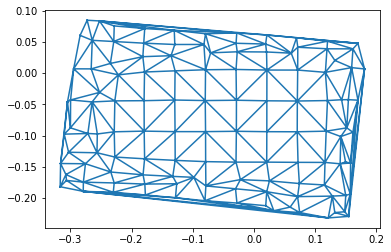

In [9]:
xy_catalog = np.array(xy_catalog)
plt.triplot(xy_catalog[:,0], xy_catalog[:,1], tri.simplices)

In [10]:
surface = o3d.geometry.TriangleMesh()
surface.vertices = o3d.utility.Vector3dVector(xyz)
surface.triangles = o3d.utility.Vector3iVector(tri.simplices)
surface.paint_uniform_color([0, 0, 1.0])
o3d.visualization.draw_geometries([surface], mesh_show_wireframe=True)

In [11]:
def get_triangles_vertices(triangles, vertices):
    triangles_vertices = []
    for triangle in triangles:
        new_triangles_vertices = [vertices[triangle[0]], vertices[triangle[1]], vertices[triangle[2]]]
        triangles_vertices.append(new_triangles_vertices)
    return np.array(triangles_vertices)

In [12]:
def volume_under_triangle(triangle):
    p1, p2, p3 = triangle
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    x3, y3, z3 = p3
    return abs((z1+z2+z3)*(x1*y2-x2*y1+x2*y3-x3*y2+x3*y1-x1*y3)/6)

In [13]:
volume = reduce(lambda a, b:  a + volume_under_triangle(b), get_triangles_vertices(surface.triangles, surface.vertices), 0)
print(f"The volume of the stockpile is: {round(volume, 4)} m3")

The volume of the stockpile is: 0.0099 m3


In [24]:
# https://github.com/isl-org/Open3D/issues/774#issuecomment-454674156
pts = np.asarray(pcd.points)

In [30]:
pts

array([[ -3.2    ,  -5.19608,  -2.     ],
       [ -3.20693,  -5.2    ,  -2.     ],
       [ -3.2    ,  -5.16835,  -1.92   ],
       ...,
       [ 12.24   ,  -5.11805, -12.08   ],
       [  3.12   ,  -4.41282, -11.12   ],
       [  3.12   ,  -4.43596, -11.2    ]])